# Cheese Clustering : by Physical characteristics

20240166 Seoyeon Shim

20240203 Hajin Kim

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
!pip install adjustText
from adjustText import adjust_text
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **1. Data Preparing & Check**

In [ ]:
file_path = '/content/drive/MyDrive/Kim_Shim_DBM2/cheeses_clustering.csv'

In [ ]:
cheese = pd.read_csv(file_path, encoding = 'EUC-KR')
print(cheese.columns)
print('Number of instances = %d' % (cheese.shape[0]))

Index(['name', 'url', 'milk', 'country', 'region', 'family', 'type',
       'fat_content', 'calcium_content', 'texture', 'rind', 'color', 'flavor',
       'aroma', 'vegetarian', 'vegan', 'synonyms', 'alt_spellings',
       'producers'],
      dtype='object')
Number of instances = 1187


# **2. Data Preprocessing**

*2-1. Drop Columns*

During the data preprocessing stage, we removed all columns unrelated to the clustering of cheeses based on their physical characteristics. Since our goal is to cluster cheeses by country according to their physical attributes, we retained only the columns relevant to this analysis: **country, texture, color, type, and rind.** All other columns were dropped to streamline the data for our clustering analysis.

In [ ]:
cheese_clean = cheese.drop(['name',	'url',	'milk',	'region',	'family',	'fat_content',	'calcium_content', 'flavor',	'aroma',	'vegetarian',	'vegan',	'synonyms',	'alt_spellings',	'producers'],axis=1)
print('Number of attributes = %d' % (cheese_clean.shape[1])) #Check the remain data
cheese_clean.head()


Number of attributes = 5


,country,type,texture,rind,color
0,Switzerland,semi-soft,buttery,washed,yellow
1,France,"semi-hard, artisan","creamy, dense, firm",natural,yellow
2,France,semi-hard,elastic,washed,ivory
3,France,"semi-soft, artisan, brined","creamy, dense, smooth",washed,white
4,France,"soft, artisan","creamy, open, smooth",washed,white


*2-2. Remove missing values*

The next step in the data preprocessing process is to remove any \N values in the dataset. Additionally, for the country, texture, type, and rind columns, if there are entries containing two or more values, **only the first value will be retained**, and the rest will be removed.

In [ ]:
print('Number of instances before replacing Null values = %d' % (cheese_clean.shape[0]))
# Remove \N values
cheese_clean = cheese_clean.replace('\\N', None)
cheese_clean = cheese_clean.dropna()
print('Number of instances After replacing Null values = %d' % (cheese_clean.shape[0]))

#Only the first value will be retained
cols_to_clean = ['country', 'texture', 'type', 'rind']

for col in cols_to_clean:
    cheese_clean[col] = cheese_clean[col].str.split(',').str[0]

cheese_clean.head()


Number of instances before replacing Null values = 1187
Number of instances After replacing Null values = 858


,country,type,texture,rind,color
0,Switzerland,semi-soft,buttery,washed,yellow
1,France,semi-hard,creamy,natural,yellow
2,France,semi-hard,elastic,washed,ivory
3,France,semi-soft,creamy,washed,white
4,France,soft,creamy,washed,white


*2-3. Frequency-based Filtering*

During the data preprocessing, rare text values with low frequency in the columns were removed. This was done by filtering out values that appeared fewer than 3 or 5 times, ensuring that only more frequent and potentially meaningful values were retained for further analysis.

In [ ]:
# Calculate the frequency of 'country' values
counts_country = cheese_clean['country'].value_counts()

# Find countries that appear between 5 and 15 times and replace with 'Others'
countries_to_replace = counts_country[(counts_country > 4) & (counts_country <= 15)].index
cheese_clean['country'] = cheese_clean['country'].replace(countries_to_replace, 'Others')

#Calculate the frequency
counts_country = cheese_clean['country'].value_counts()
counts_type = cheese_clean['type'].value_counts()
counts_texture = cheese_clean['texture'].value_counts()
counts_rind = cheese_clean['rind'].value_counts()
counts_color = cheese_clean['color'].value_counts()

#Print values that appear too rare
print("Rare values: ")
print(counts_country[counts_country <= 4])
print(counts_type[counts_type <= 5])
print(counts_texture[counts_texture <= 5])
print(counts_rind[counts_rind <= 5])
print(counts_color[counts_color <= 5])

# Remove outliers based on low frequency values in each column
cheese_clean = cheese_clean[ #To remove only once in each column
    cheese_clean['country'].isin(counts_country[counts_country > 4].index) &
    cheese_clean['type'].isin(counts_type[counts_type > 5].index) &
    cheese_clean['texture'].isin(counts_texture[counts_texture > 5].index) &
    cheese_clean['rind'].isin(counts_rind[counts_rind > 5].index) &
    cheese_clean['color'].isin(counts_color[counts_color > 5].index)
]

print('Number of instances After Frequency-based Filtering  = %d' % (cheese_clean.shape[0]))

Rare values: 
country
Sweden                  4
Great Britain           4
New Zealand             4
India                   4
Portugal                4
Croatia                 3
Brazil                  3
Mexico                  3
Hungary                 3
Cyprus                  3
Greece                  3
Wales                   2
China                   2
Finland                 2
Mexico and Caribbean    2
Middle East             2
Egypt                   1
Argentina               1
Poland                  1
Chile                   1
Bangladesh              1
Lebanon                 1
Lithuania               1
Czech Republic          1
Bulgaria                1
Mauritania              1
Mongolia                1
Albania                 1
Name: count, dtype: int64
type
artisan    1
Name: count, dtype: int64
texture
open            5
soft-ripened    4
flaky           3
supple          3
crystalline     3
dry             3
grainy          2
runny           2
spreadable      1
oily      

#**3. Exploratory Data Analysis (EDA)**

Before proceeding with the clustering process, we conducted an initial exploratory data analysis (EDA) to visualize the distribution of cheese characteristics across different countries. This step helped us understand which features are most prevalent in each country's cheeses and allowed us to observe potential patterns and relationships.

<ipython-input-8-7881bb22bb5a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cheese_clean['country_encoded'] = le_country.fit_transform(cheese_clean['country'])


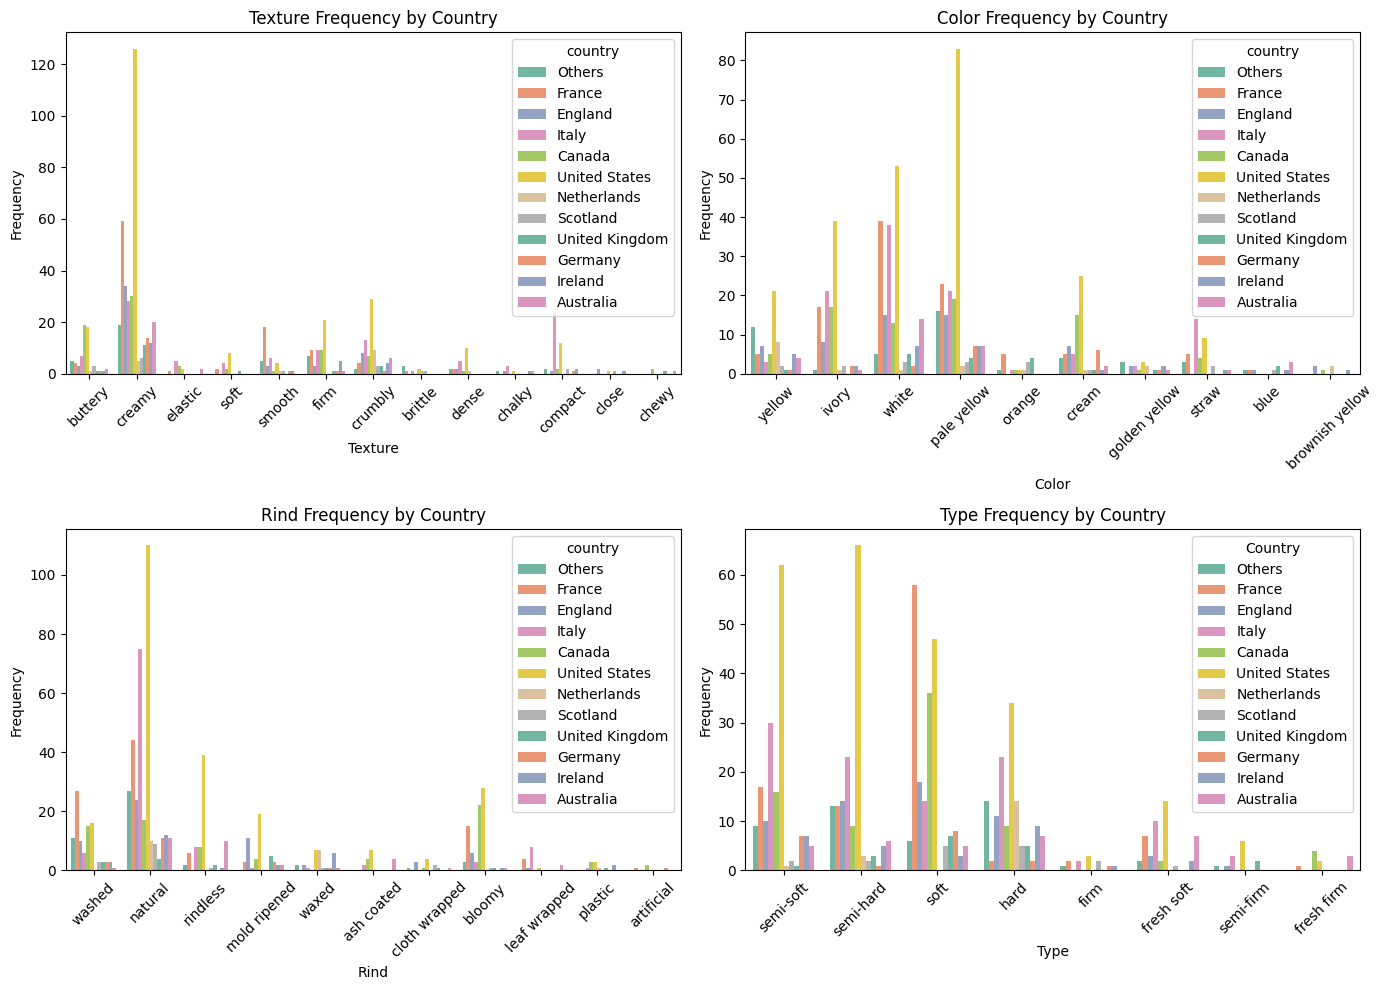

In [ ]:
#Make subplots to display 4 graphs in once
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#Encoding countries' name
le_country = LabelEncoder()
cheese_clean['country_encoded'] = le_country.fit_transform(cheese_clean['country'])

#Graph of 'texture'
sns.countplot(data=cheese_clean, x='texture', hue='country', palette='Set2', ax=axes[0, 0])
axes[0, 0].set_title('Texture Frequency by Country')
axes[0, 0].set_xlabel('Texture')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].tick_params(axis='x', rotation=45)

#Graph of 'color'
sns.countplot(data=cheese_clean, x='color', hue='country', palette='Set2', ax=axes[0, 1])
axes[0, 1].set_title('Color Frequency by Country')
axes[0, 1].set_xlabel('Color')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].tick_params(axis='x', rotation=45)

#Graph of 'rind'
sns.countplot(data=cheese_clean, x='rind', hue='country', palette='Set2', ax=axes[1, 0])
axes[1, 0].set_title('Rind Frequency by Country')
axes[1, 0].set_xlabel('Rind')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].tick_params(axis='x', rotation=45)

#Graph of 'type'
sns.countplot(data=cheese_clean, x='type', hue='country', palette='Set2', ax=axes[1, 1])
axes[1, 1].set_title('Type Frequency by Country')
axes[1, 1].set_xlabel('Type')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.legend(title='Country', loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
#Check the null data finally
print(cheese_clean.isnull().sum())

country            0
type               0
texture            0
rind               0
color              0
country_encoded    0
dtype: int64


# **4. K-Mean Clustering**

The first clustering method applied was K-means clustering.
However, since texture and type are not continuous numerical features, clustering posed some challenges. To address this, texture and type were mapped to values between 0 and 1, with the softest and smoothest attributes set to 0 and the hardest and firmest attributes set to 1.

After mapping these attributes, K-means clustering was performed on 750 cheese samples using these two criteria. To better visualize the results and observe the countries associated with each cluster, the data was represented in a 3D scatter plot. Each point in the plot represents a cheese sample, with colors indicating different clusters and edge colors distinguishing the countries.



      texture        type  type_mapped  Cluster_Texture_Type
0     buttery   semi-soft          0.4                     4
1      creamy   semi-hard          0.9                     0
2     elastic   semi-hard          0.9                     0
3      creamy   semi-soft          0.4                     4
4      creamy        soft          0.1                     1
...       ...         ...          ...                   ...
1174   creamy   semi-soft          0.4                     4
1179  compact   semi-hard          0.9                     2
1180   creamy        soft          0.1                     1
1183   creamy  fresh firm          0.5                     4
1186     firm        hard          1.0                     2

[750 rows x 4 columns]


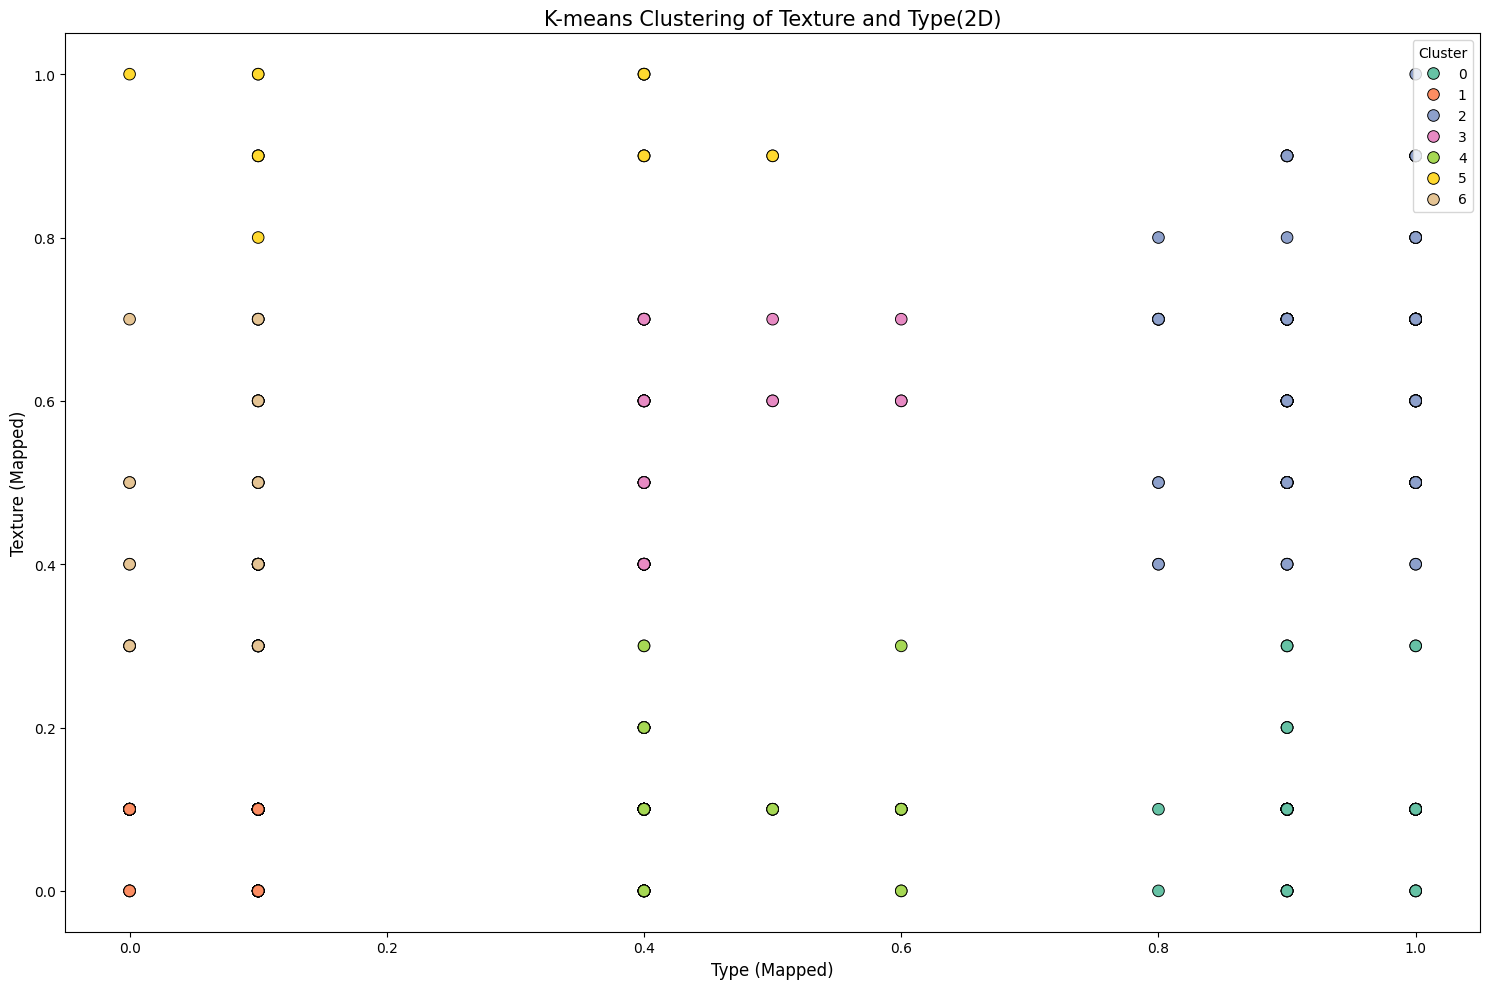

In [ ]:
#Mapping
type_mapping = {
    'fresh soft': 0.0,
    'soft': 0.1,
    'semi-soft': 0.4,
    'fresh firm': 0.5,
    'semi-firm': 0.6,
    'firm': 0.8,
    'semi-hard': 0.9,
    'hard': 1.0
}

texture_mapping = {
    'buttery': 0.0,
    'creamy': 0.1,
    'elastic': 0.2,
    'soft': 0.3,
    'smooth': 0.4,
    'firm': 0.6,
    'crumbly': 0.7,
    'brittle': 0.8,
    'dense': 0.9,
    'chalky': 1.0,
    'compact': 0.5,
    'close': 0.3,
    'chewy': 0.5
}

#Create new column of mapped values
cheese_clean['texture_mapped'] = cheese_clean['texture'].map(texture_mapping)
cheese_clean['type_mapped'] = cheese_clean['type'].map(type_mapping)


features_texture_type = ['texture_mapped', 'type_mapped']

#K-means clustering
kmeans_texture_type = KMeans(n_clusters=7, random_state=20)
cheese_clean['Cluster_Texture_Type'] = kmeans_texture_type.fit_predict(cheese_clean[features_texture_type])

#Pring mapping result
print(cheese_clean[['texture', 'type', 'type_mapped', 'Cluster_Texture_Type']])

#2D plotting
plt.figure(figsize=(15, 10))
palette = sns.color_palette('Set2', n_colors=7)

sns.scatterplot(
    data=cheese_clean,
    x='type_mapped',
    y='texture_mapped',
    hue='Cluster_Texture_Type',
    palette=palette,
    s=70,
    edgecolor='k'
)

plt.title('K-means Clustering of Texture and Type(2D)', fontsize=15)
plt.xlabel('Type (Mapped)', fontsize=12)
plt.ylabel('Texture (Mapped)', fontsize=12)
plt.legend(title='Cluster', loc='upper right')


plt.tight_layout()
plt.show()



In [ ]:
#Mapping country with numbers
country_mapping = {country: i for i, country in enumerate(cheese_clean['country'].unique())}
cheese_clean['country_mapped'] = cheese_clean['country'].map(country_mapping)

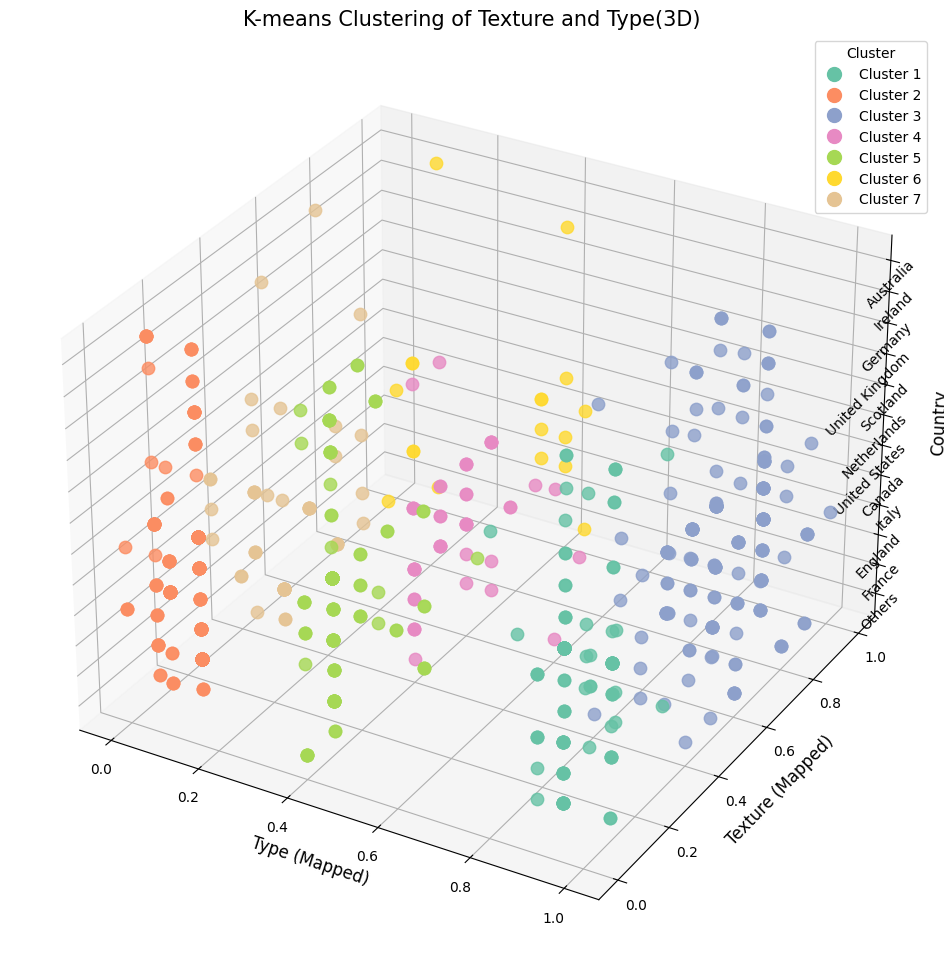

In [ ]:
#3D plotting
fig = plt.figure(figsize=(16, 12))
ax1 = fig.add_subplot(111, projection='3d')

num_clusters = cheese_clean['Cluster_Texture_Type'].nunique()
palette = sns.color_palette('Set2', n_colors=num_clusters)

for _, row in cheese_clean.iterrows():
    ax1.scatter(
        row['type_mapped'],
        row['texture_mapped'],
        row['country_mapped'],
        color=palette[row['Cluster_Texture_Type'] % num_clusters],
        s=80,
        alpha=0.8
    )

#Axis
ax1.set_xlabel('Type (Mapped)', fontsize=12)
ax1.set_ylabel('Texture (Mapped)', fontsize=12)
ax1.set_zlabel('Country', fontsize=12)
ax1.set_zticks(list(country_mapping.values()))
ax1.set_zticklabels(list(country_mapping.keys()), fontsize=10, rotation=45, ha='right')

ax1.set_title('K-means Clustering of Texture and Type(3D)', fontsize=15)

#Legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=palette[i], markersize=10, linestyle='None',
                                 label=f'Cluster {i + 1}') for i in range(num_clusters)]
ax1.legend(handles=legend_elements, title="Cluster", loc='upper right')

plt.show()


To ensure each point's country identity is clearly visible in the 3D graph, different border colors were added to the points based on their respective countries. This allows for easier distinction of the countries within each cluster.

<ipython-input-13-63869f3fb4c4>:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


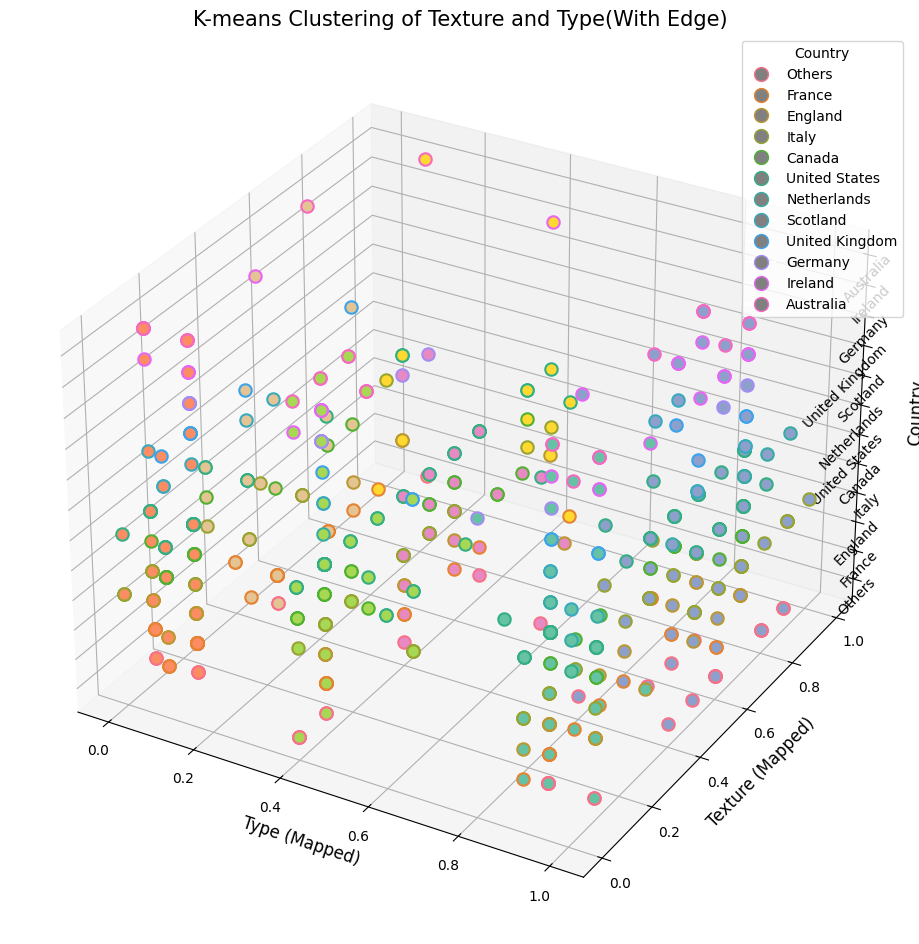

In [ ]:
#Different border colors
unique_countries = cheese_clean['country'].unique()
country_colors = sns.color_palette('husl', n_colors=len(unique_countries))
country_color_map = dict(zip(unique_countries, country_colors))

#3D plotting
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection='3d')

for _, row in cheese_clean.iterrows():
    ax.scatter(
        row['type_mapped'],
        row['texture_mapped'],
        row['country_mapped'],
        c=plt.cm.Set2(row['Cluster_Texture_Type']),
        edgecolor=country_color_map[row['country']],
        s=80,
        linewidth=1.5
    )

#Axis label
ax.set_xlabel('Type (Mapped)', fontsize=12)
ax.set_ylabel('Texture (Mapped)', fontsize=12)
ax.set_zlabel('Country', fontsize=12)
ax.set_zticks(list(country_mapping.values()))
ax.set_zticklabels(list(country_mapping.keys()), fontsize=10)

#Border colors label
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                              markeredgecolor=country_color_map[country], markersize=10,
                              label=country) for country in unique_countries]

ax.legend(handles=legend_elements, title="Country", loc='upper right', fontsize=10)

ax.set_zticks(list(country_mapping.values()))
ax.set_zticklabels(list(country_mapping.keys()), fontsize=10, rotation=45, ha='right')
ax.set_title('K-means Clustering of Texture and Type(With Edge)', fontsize=15)

plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.1)
plt.show()

# **5. Hierarchical Clustering**

For the second clustering method, hierarchical clustering was used. The mapped texture and type values were employed to calculate the similarity between different cheeses, and a dendrogram was generated to visualize the relationships.



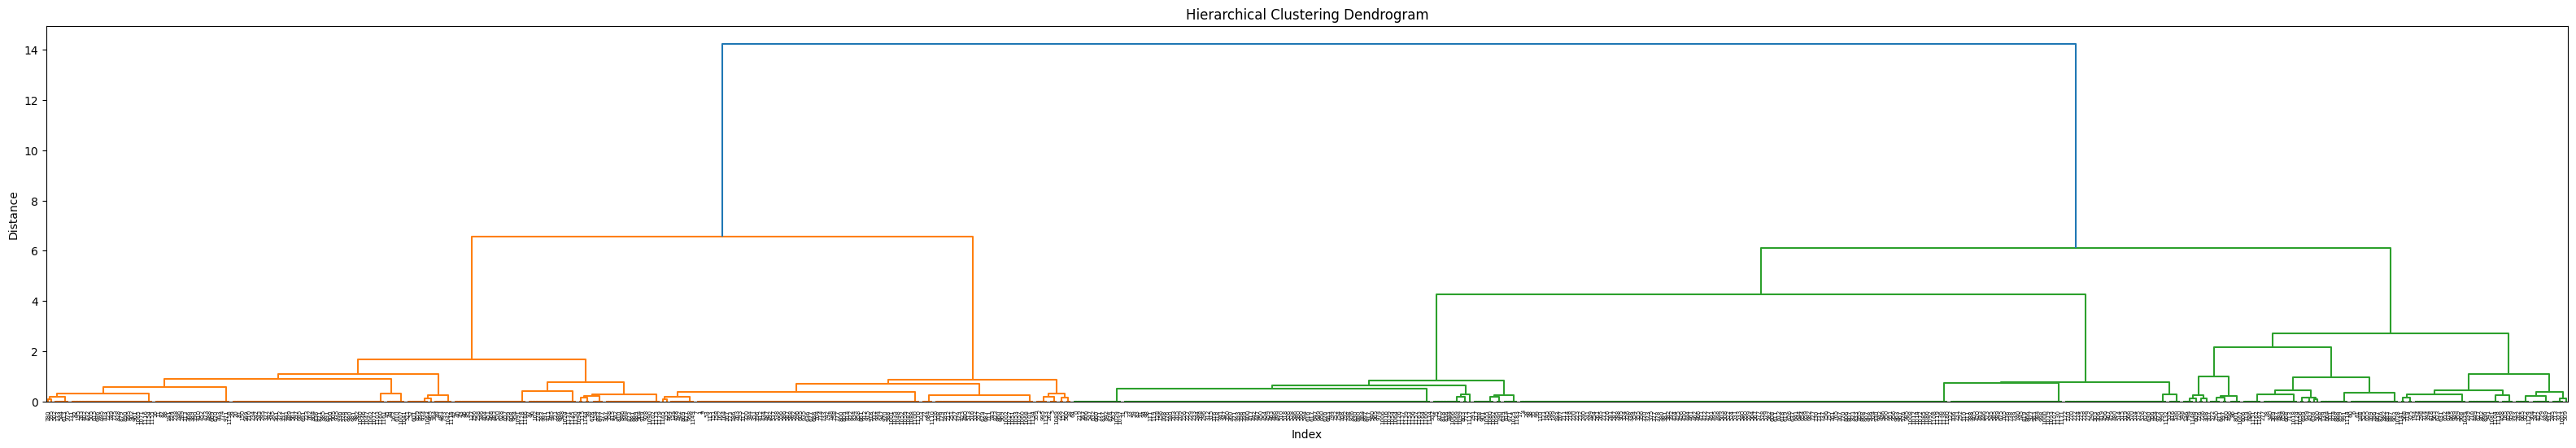

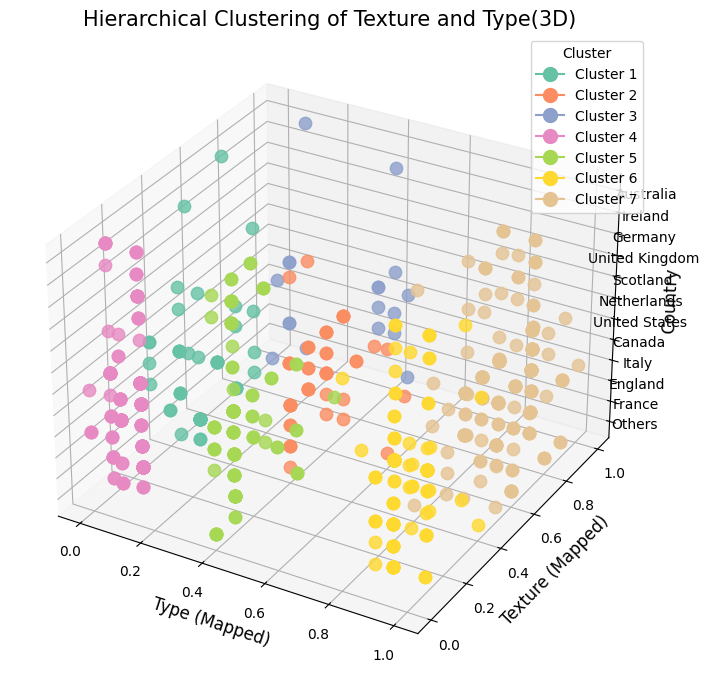

In [ ]:
features_texture_type_hier = cheese_clean[['type_mapped', 'texture_mapped']]
linked = linkage(features_texture_type_hier, method='ward')

#Visualize Dendrogram
plt.figure(figsize=(40, 6))
dendrogram(linked,
           orientation='top',
           labels=cheese_clean.index,
           distance_sort='descending',
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()

#Number of Clusters = 7 ; Same as K-maens clustering
cheese_clean['Cluster_Hierarchical'] = fcluster(linked, t=7, criterion='maxclust')


#3D plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

palette = sns.color_palette('Set2', n_colors=cheese_clean['Cluster_Hierarchical'].nunique())
cluster_colors = dict(zip(sorted(cheese_clean['Cluster_Hierarchical'].unique()), palette))

for _, row in cheese_clean.iterrows():
    ax.scatter(
        row['type_mapped'],
        row['texture_mapped'],
        row['country_mapped'],
        color=cluster_colors[row['Cluster_Hierarchical']],
        s = 80,
        alpha=0.8
    )


#Axis label
ax.set_xlabel('Type (Mapped)', fontsize=12)
ax.set_ylabel('Texture (Mapped)', fontsize=12)
ax.set_zlabel('Country', fontsize=12)

ax.set_zticks(list(country_mapping.values()))
ax.set_zticklabels(list(country_mapping.keys()), fontsize=10)

#Legend
legend_elements = [plt.Line2D([0], [0], marker='o', color=color, markersize=10, label=f'Cluster {cluster}')
                   for cluster, color in cluster_colors.items()]
ax.legend(handles=legend_elements, title="Cluster", loc='upper right')


ax.set_title('Hierarchical Clustering of Texture and Type(3D)', fontsize=15)


plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

## **6. Summary**


In conclusion, through this series of clustering processes, we observed that the 3D plot results of K-means clustering and hierarchical clustering were quite similar. The cheeses were effectively grouped into seven clusters based on their texture and type. When analyzed together with the country of origin, there were some overlaps, but we also found that cheeses from the same country could exhibit diverse characteristics.

Due to the nature of the data, where cheese attributes were not continuous numerical values, clustering posed some challenges. Nevertheless, we are highly satisfied with the clustering results. For future clustering efforts, selecting appropriate datasets will be an important factor to consider.

